# Instalación de paquetes

# Imports

In [2]:
import os
import shutil
import rasterio
from rasterio.plot import show
import multiprocessing as mp
from collections import namedtuple

import torch
from torch.utils.data import (
    ConcatDataset,
    random_split,
) 

from rastervision.core.data import (
    ClassConfig,
    ReclassTransformer,
    SemanticSegmentationLabels,
)
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer,
    SemanticSegmentationGeoDataConfig,
    SolverConfig,
    Backbone,
    SemanticSegmentationModelConfig,
    SemanticSegmentationLearnerConfig,
    SemanticSegmentationLearner,
)

d:\__repos\aerial_segmentation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Variables globales

In [3]:
INPUT_DIR = '/kaggle/input/inria-aerial-image-labeling-dataset/AerialImageDataset'
OUTPUT_DIR = '/kaggle/working/'

TEST_DIR = 'test'
TRAIN_DIR = 'train'

LABEL_DIR = 'gt'
IMG_DIR = 'images'

EPOCHS = 1
LR = 1e-5

IN_CHANNELS = 3
IMG_SIZE = 512
MAX_WINDOWS = 100
BATCH_SIZE = 8

DEVICE, NUM_DEVICES = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", mp.cpu_count())
WORKERS = mp.cpu_count()
print(f'Running on {NUM_DEVICES} {DEVICE}(s) with {WORKERS} workers')

Running on 1 cuda(s) with 4 workers


# Código para borrar na carpeta de salida

In [4]:
try:
    shutil.rmtree(OUTPUT_DIR)
except:
    pass

# Chequear nuestras imágenes

In [5]:
with rasterio.open('/kaggle/input/inria-aerial-image-labeling-dataset/AerialImageDataset/train/images/austin1.tif') as src:
    largo = src.width
    altura = src.height
    transform = src.transform
    
    print(f'Largo: {largo}')
    print(f'Altura: {altura}')
    print(f'Transform: {transform}')
    
with rasterio.open('/kaggle/input/inria-aerial-image-labeling-dataset/AerialImageDataset/train/gt/austin1.tif') as src:
    largo = src.width
    altura = src.height
    transform = src.transform
    
    print(f'Largo: {largo}')
    print(f'Altura: {altura}')
    print(f'Transform: {transform}')

Largo: 5000
Altura: 5000
Transform: | 0.30, 0.00, 616500.00|
| 0.00,-0.30, 3345000.00|
| 0.00, 0.00, 1.00|
Largo: 5000
Altura: 5000
Transform: | 0.30, 0.00, 616500.00|
| 0.00,-0.30, 3345000.00|
| 0.00, 0.00, 1.00|


# Configuración de clases

In [6]:
class_config = ClassConfig(
    names=['background', 'building'],
    colors=['black', 'white'],
    null_class='background',
)

# Creando las direcciones para imágenes y rótulos

In [7]:
DataTuple = namedtuple('DataTuple', 'image gt')

def create_trainig_data(imageroot, labelroot):
    training_dict = {}
    for file in os.listdir(labelroot):
        training_dict[file] = DataTuple(
            image=os.path.join(imageroot, file),
            gt=os.path.join(labelroot, file),
        )
    return training_dict

training_dict = create_trainig_data(
    imageroot=os.path.join(INPUT_DIR, TRAIN_DIR, IMG_DIR),
    labelroot=os.path.join(INPUT_DIR, TRAIN_DIR, LABEL_DIR),
)

print(len(training_dict))

180


# Creando nuestro visualizador

In [8]:
viz = SemanticSegmentationVisualizer(
    class_names=class_config.names,
    class_colors=class_config.colors
)

# Creando nuestro dataset

In [9]:
def create_concat_dataset(data_dict):
    datasets = []
    for file in data_dict.keys():
        ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
            class_config=class_config,
            image_uri=data_dict[file].image,
            label_raster_uri=data_dict[file].gt,
            size_lims=(IMG_SIZE, 2*IMG_SIZE),
            out_size=IMG_SIZE,
            max_windows=MAX_WINDOWS,
            label_raster_source_kw=dict(raster_transformers=[ReclassTransformer({255: 1})]),
        )
        datasets.append(ds)
    return ConcatDataset(datasets)

concat_dataset = create_concat_dataset(training_dict)

print(len(concat_dataset))

18000


# Dividiendo nuestro concat dataset en validación, entrenaminto y prueba

In [10]:
train_set, val_set, test_set = random_split(concat_dataset, [0.6, 0.2, 0.2])

print(len(train_set), len(val_set), len(test_set))

10800 3600 3600


# Chequear nuestro train dataset

In [11]:
x, y = train_set[0]
print(x.shape, y.shape)
print(y.unique())

torch.Size([3, 512, 512]) torch.Size([512, 512])
tensor([0, 1])


# Visualizando los datos de entrenamiento

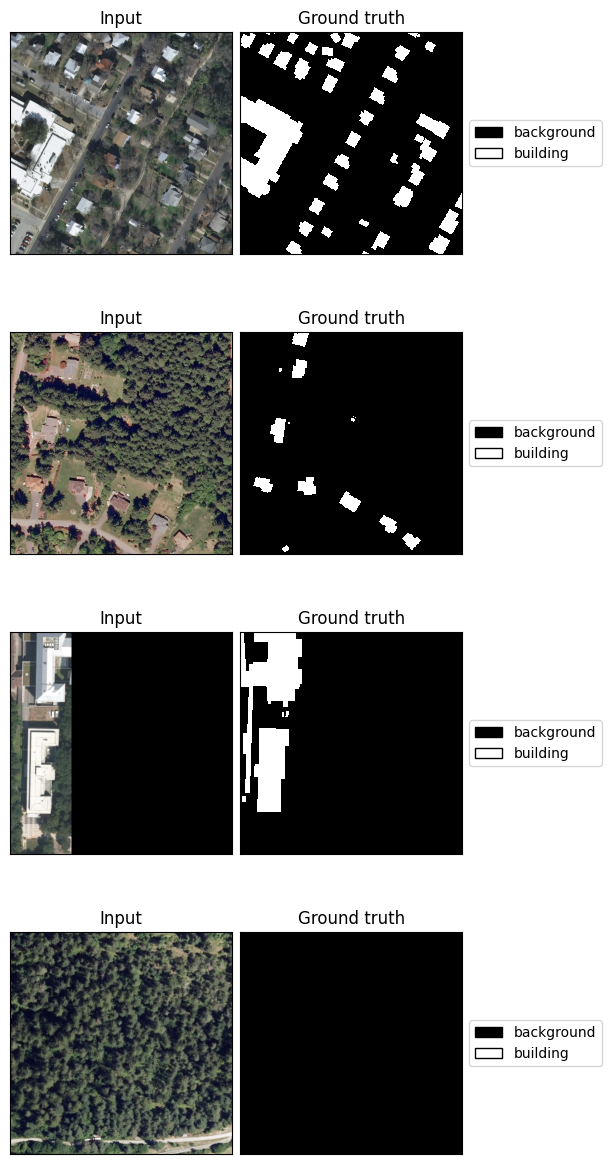

In [12]:
x, y = viz.get_batch(train_set, 4)
viz.plot_batch(x, y, show=True)

# Configurar el entrenamiento

In [15]:
data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=WORKERS,
    img_channels=IN_CHANNELS,
)

solver_cfg = SolverConfig(
    batch_sz=BATCH_SIZE,
    lr=LR,
)

model_config = SemanticSegmentationModelConfig(
    backbone=Backbone.resnet50,
    pretrained=True,
)

learner_config = SemanticSegmentationLearnerConfig(
    data=data_cfg,
    solver=solver_cfg,
    model=model_config,
)

# El entrenamiento propiamente dicho

In [18]:
learner = SemanticSegmentationLearner(
    cfg=learner_config,
    output_dir=OUTPUT_DIR,
    train_ds=train_set,
    valid_ds=val_set,
    test_ds=test_set,
    training=True,
)

learner.log_data_stats()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 44.1MB/s]
2023-12-06 16:33:25:rastervision.pytorch_learner.learner: INFO - train_ds: 10800 items
2023-12-06 16:33:25:rastervision.pytorch_learner.learner: INFO - valid_ds: 3600 items
2023-12-06 16:33:25:rastervision.pytorch_learner.learner: INFO - test_ds: 3600 items


In [19]:
learner.train(epochs=EPOCHS)

2023-12-06 16:34:22:rastervision.pytorch_learner.learner: INFO - epoch: 0


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validating:   0%|          | 0/450 [00:00<?, ?it/s]

2023-12-06 17:09:18:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'train_loss': 0.485120564699173,
 'train_time': '0:31:36.308352',
 'val_loss': 0.3604528307914734,
 'avg_precision': 0.9147449731826782,
 'avg_recall': 0.9113153219223022,
 'avg_f1': 0.9130269289016724,
 'background_precision': 0.9547796845436096,
 'background_recall': 0.9414365291595459,
 'background_f1': 0.9480611681938171,
 'building_precision': 0.6693284511566162,
 'building_recall': 0.7266690731048584,
 'building_f1': 0.6968210935592651,
 'valid_time': '0:03:20.275571'}


# Examinando nuestras predicciones

2023-12-06 17:10:00:rastervision.pytorch_learner.learner: INFO - Making and plotting sample predictions on the test set...


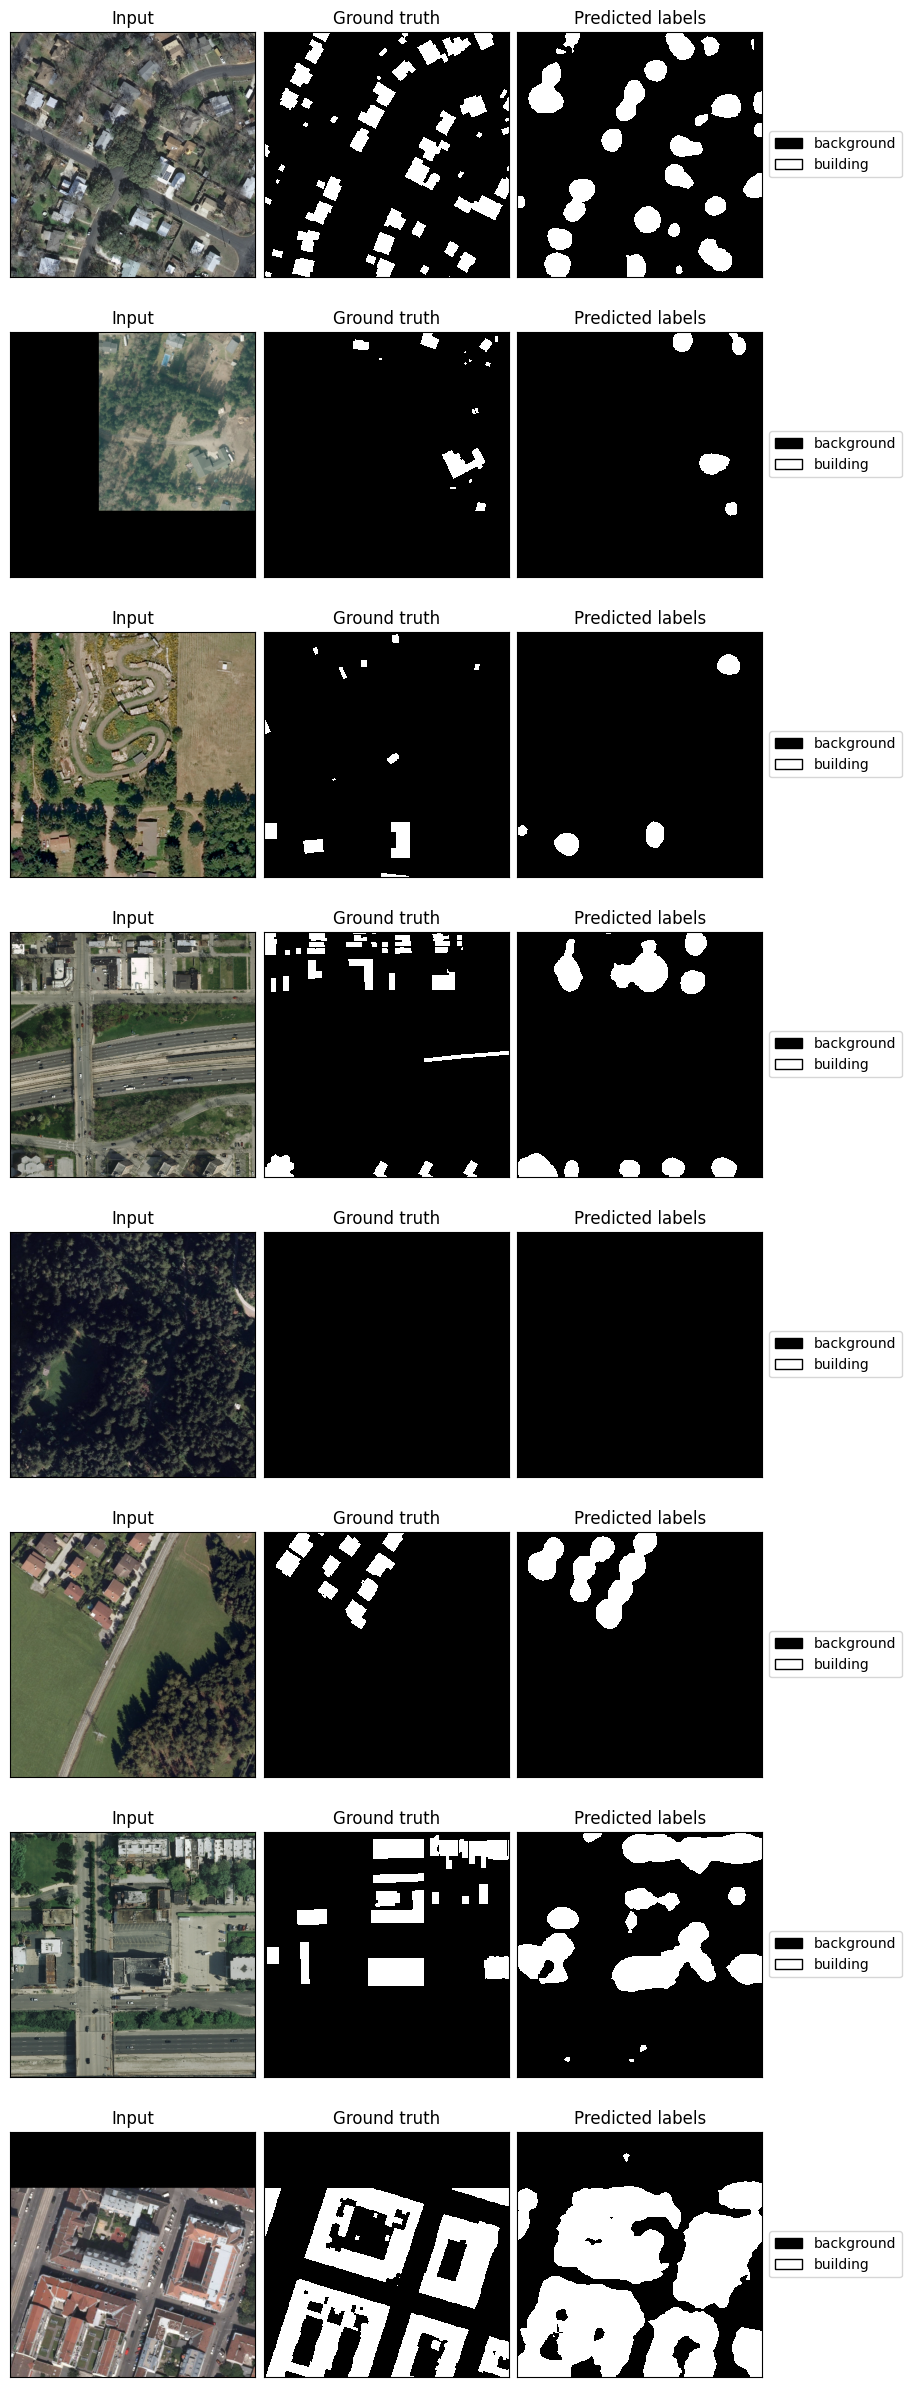

2023-12-06 17:10:05:rastervision.pytorch_learner.learner: INFO - Sample predictions written to /kaggle/working/test_preds.png.


<Figure size 640x480 with 0 Axes>

In [20]:
learner.plot_predictions(
    split='test',
    show=True,
)

# Guardando nuestros datos para el futuro

In [21]:
learner.save_model_bundle()

2023-12-06 17:11:07:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2023-12-06 17:11:09:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



2023-12-06 17:11:12:rastervision.pytorch_learner.learner: INFO - Saving bundle to /kaggle/working/model-bundle.zip.


# Cargar nuestros datos en modo de predición

In [24]:
bundle_uri = os.path.join(OUTPUT_DIR, 'model-bundle.zip')

predictlearner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri=bundle_uri,
    training=False,
    output_dir=OUTPUT_DIR,
)

predictlearner.log_data_stats()

2023-12-06 17:12:33:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle /kaggle/working/model-bundle.zip.
2023-12-06 17:12:33:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmppssi0pnd/model-bundle
2023-12-06 17:12:36:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmppssi0pnd/model-bundle/model.pth


# Haciendo predicciones

In [28]:
prediction_dataset = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri='/kaggle/input/inria-aerial-image-labeling-dataset/AerialImageDataset/test/images/bellingham1.tif',
    size=1024,
    stride=1024,
)

predictions = predictlearner.predict_dataset(
    dataset=prediction_dataset,
    raw_out=False,
    numpy_out=True,
    predict_kw=dict(out_shape=1024),
    progress_bar=True,
)

pred_labels = SemanticSegmentationLabels.from_predictions(
    windows=prediction_dataset.windows,
    predictions=predictions,
    smooth=False,
    extent=prediction_dataset.scene.extent,
    num_classes=len(class_config.names),
)

Predicting:   0%|          | 0/25 [00:00<?, ?it/s]

# Guardar las predicciones en disco

In [29]:
predictions_path = os.path.join(OUTPUT_DIR, 'predictions')

pred_labels.save(
    uri=predictions_path,
    crs_transformer=prediction_dataset.scene.raster_source.crs_transformer,
    class_config=class_config,
    save_as_rgb=False,
    raster_output=True,
)

Saving pixel labels:   0%|          | 0/10 [00:00<?, ?it/s]

# Visualizando las predicciones

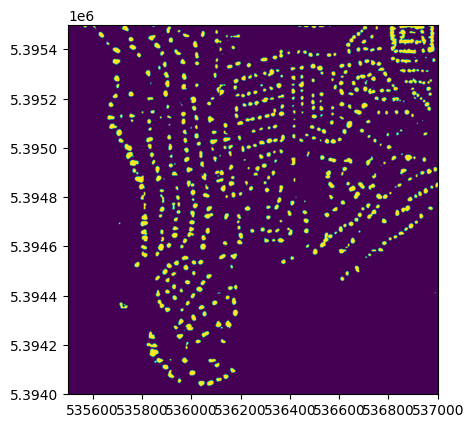

<Axes: >

In [30]:
output_filepath = os.path.join(predictions_path, 'labels.tif')
src = rasterio.open(output_filepath)
show(src.read(), transform=src.transform)